In [1]:
import sys, os
sys.path.append('./src')

import torch
import numpy as np
import torch.nn.functional as F
import torch.optim as opt
from torch.nn import Module, Parameter
from sklearn.cluster import KMeans
import utils

# from umap import UMAP
from sklearn.decomposition import PCA

In [3]:
class cfrmModel(Module):
    def __init__(self, dir, N=3, batch_size=100, lr=1e-3, dropout=0.1):
        super().__init__()
        self.batch_size = batch_size
        self.alpha = torch.FloatTensor([1, 1, 1, 1, 1])
        self.dropout = dropout
        # data
        counts_rna = np.loadtxt(os.path.join(dir, 'GxC1.txt')).T
        counts_atac = np.loadtxt(os.path.join(dir, 'RxC2.txt')).T
        
        counts_rna = utils.preprocess(counts = counts_rna, mode = "quantile", modality = "RNA")
        counts_atac = utils.preprocess(counts = counts_atac, mode = "quantile", modality= "ATAC")

        self.G = torch.FloatTensor(counts_rna)
        self.R = torch.FloatTensor(counts_atac)
        self.A = torch.FloatTensor(np.loadtxt(os.path.join(dir, 'RxG.txt')))
        assert self.A.shape[0] == self.R.shape[1]
        assert self.A.shape[1] == self.G.shape[1]
        self.label_g = torch.LongTensor(np.loadtxt(os.path.join(dir, 'gene_label.txt')))
        self.label_c1 = torch.LongTensor(np.loadtxt(os.path.join(dir, 'cell_label_C1.txt'), skiprows=1, usecols=[1]))
        self.label_c2 = torch.LongTensor(np.loadtxt(os.path.join(dir, 'cell_label_C2.txt'), skiprows=1, usecols=[1]))
        # learnable parameters
        self.A_1g = Parameter(torch.eye(N))
        self.A_2r = Parameter(torch.eye(N))
        self.D_gr = Parameter(torch.ones(N, 1))
        self.D_12 = Parameter(torch.ones(N, 1))
        u, s, v = torch.svd(self.G)
        self.C_1g = Parameter(torch.FloatTensor(u[:, :N]))
        self.alpha[0] = 1 / s[0]
        u, s, v = torch.svd(self.R)
        self.C_2r = Parameter(torch.FloatTensor(u[:, :N]))
        self.alpha[1] = 1 / s[0]
        u, s, v = torch.svd(self.A)
        self.C_r = Parameter(torch.FloatTensor(u[:, :N]))
        self.C_g = Parameter(torch.FloatTensor(v[:, :N]))
        self.alpha[2] = 1 / s[0]
        # optimizer
        self.optimizer = opt.Adam(self.parameters(), lr=lr)

    @staticmethod
    def orthogonal_loss(A):
        return (A.t() @ A - torch.eye(A.shape[1])).pow(2).sum()

    def batch_loss(self):
        loss1 = (self.G - self.C_1g @ self.A_1g @ self.C_g.t()).abs().sum()
        loss2 = (self.R - self.C_2r @ self.A_2r @ self.C_r.t()).abs().sum()
        loss3 = (self.A - self.C_r @ (self.D_gr * self.C_g.t())).abs().sum()
        loss4 = (self.A_1g - self.D_12 * self.A_2r).pow(2).mean()
        loss5 = sum(map(self.orthogonal_loss, [self.C_1g, self.C_2r, self.C_g, self.C_r]))
        loss = self.alpha[0] * loss1 + self.alpha[1] * loss2 + self.alpha[2] * loss3 + self.alpha[3] * loss4 + self.alpha[4] * loss5
        return loss, self.alpha[0] * loss1, self.alpha[1] * loss2, self.alpha[2] * loss3, self.alpha[3] * loss4, self.alpha[4] * loss5

    def train_func(self, T):
        best_loss = 1e8
        count = 0
        for t in range(T):
            self.optimizer.zero_grad()
            loss, loss1, loss2, loss3, loss4, loss5 = self.batch_loss()
            loss.backward()
            self.optimizer.step()
            if loss.item() < best_loss:
                best_loss = loss.item()
                count = 0
            else:
                count += 1
                if count % 20 == 0:
                    self.optimizer.param_groups[0]['lr'] *= 0.5
                    print('Epoch: {}, shrink lr to {:.4f}'.format(t+1, self.optimizer.param_groups[0]['lr']))
                    if self.optimizer.param_groups[0]['lr'] < 1e-4:
                        break
                    else:
                        count = 0
            info = [
                'loss RNA: {:.5f}'.format(loss1.item()),
                'loss ATAC: {:.5f}'.format(loss2.item()),
                'loss gene act: {:.5f}'.format(loss3.item()),
                'loss merge: {:.5f}'.format(loss4.item()),
                'loss ortho: {:.5f}'.format(loss5.item()),
                
            ]

            print('Epoch {}, Training Loss: {:.4f}'.format(t+1, loss.item()))

            for i in info:
                print("\t", i)






In [4]:
model = cfrmModel(dir = './data/simulated/2batches_3clusts', N=3, dropout=0)
model.train_func(T=10000)

Epoch 1, Training Loss: 4010.1616
	 loss RNA: 1925.98486
	 loss ATAC: 1178.04102
	 loss gene act: 906.13562
	 loss merge: 0.00000
	 loss ortho: 0.00000
Epoch 2, Training Loss: 4021.7307
	 loss RNA: 1925.95154
	 loss ATAC: 1178.09045
	 loss gene act: 917.65796
	 loss merge: 0.00000
	 loss ortho: 0.03081
Epoch 3, Training Loss: 4015.4009
	 loss RNA: 1925.96826
	 loss ATAC: 1178.05359
	 loss gene act: 911.35944
	 loss merge: 0.00001
	 loss ortho: 0.01960
Epoch 4, Training Loss: 4013.8379
	 loss RNA: 1925.99048
	 loss ATAC: 1178.03906
	 loss gene act: 909.80017
	 loss merge: 0.00001
	 loss ortho: 0.00824
Epoch 5, Training Loss: 4017.1909
	 loss RNA: 1925.99414
	 loss ATAC: 1178.05286
	 loss gene act: 913.14014
	 loss merge: 0.00002
	 loss ortho: 0.00380
Epoch 6, Training Loss: 4017.7708
	 loss RNA: 1925.98865
	 loss ATAC: 1178.05591
	 loss gene act: 913.72369
	 loss merge: 0.00004
	 loss ortho: 0.00264
Epoch 7, Training Loss: 4015.7788
	 loss RNA: 1925.97632
	 loss ATAC: 1178.03979
	 loss 

Epoch 56, Training Loss: 4010.1770
	 loss RNA: 1925.93982
	 loss ATAC: 1177.86926
	 loss gene act: 906.34619
	 loss merge: 0.00054
	 loss ortho: 0.02112
Epoch 57, Training Loss: 4010.1689
	 loss RNA: 1925.93994
	 loss ATAC: 1177.86816
	 loss gene act: 906.33868
	 loss merge: 0.00054
	 loss ortho: 0.02176
Epoch 58, Training Loss: 4010.1333
	 loss RNA: 1925.94055
	 loss ATAC: 1177.86694
	 loss gene act: 906.30261
	 loss merge: 0.00055
	 loss ortho: 0.02240
Epoch 59, Training Loss: 4010.0833
	 loss RNA: 1925.94177
	 loss ATAC: 1177.86584
	 loss gene act: 906.25226
	 loss merge: 0.00055
	 loss ortho: 0.02303
Epoch 60, Training Loss: 4010.0557
	 loss RNA: 1925.94238
	 loss ATAC: 1177.86475
	 loss gene act: 906.22443
	 loss merge: 0.00055
	 loss ortho: 0.02364
Epoch 61, Training Loss: 4010.0903
	 loss RNA: 1925.94336
	 loss ATAC: 1177.86377
	 loss gene act: 906.25854
	 loss merge: 0.00055
	 loss ortho: 0.02423
Epoch 62, Training Loss: 4010.1106
	 loss RNA: 1925.94385
	 loss ATAC: 1177.86267


Epoch 111, Training Loss: 4009.8987
	 loss RNA: 1925.92969
	 loss ATAC: 1177.81995
	 loss gene act: 906.08752
	 loss merge: 0.00065
	 loss ortho: 0.06113
Epoch 112, Training Loss: 4009.8713
	 loss RNA: 1925.92847
	 loss ATAC: 1177.81921
	 loss gene act: 906.06110
	 loss merge: 0.00065
	 loss ortho: 0.06189
Epoch 113, Training Loss: 4009.8770
	 loss RNA: 1925.92700
	 loss ATAC: 1177.81860
	 loss gene act: 906.06781
	 loss merge: 0.00065
	 loss ortho: 0.06267
Epoch 114, Training Loss: 4009.8867
	 loss RNA: 1925.92566
	 loss ATAC: 1177.81799
	 loss gene act: 906.07886
	 loss merge: 0.00065
	 loss ortho: 0.06346
Epoch 115, Training Loss: 4009.8750
	 loss RNA: 1925.92554
	 loss ATAC: 1177.81726
	 loss gene act: 906.06744
	 loss merge: 0.00065
	 loss ortho: 0.06429
Epoch 116, Training Loss: 4009.8567
	 loss RNA: 1925.92639
	 loss ATAC: 1177.81665
	 loss gene act: 906.04767
	 loss merge: 0.00065
	 loss ortho: 0.06514
Epoch 117, Training Loss: 4009.8496
	 loss RNA: 1925.92749
	 loss ATAC: 1177

Epoch 166, Training Loss: 4009.7554
	 loss RNA: 1925.91846
	 loss ATAC: 1177.79419
	 loss gene act: 905.93597
	 loss merge: 0.00073
	 loss ortho: 0.10590
Epoch 167, Training Loss: 4009.7546
	 loss RNA: 1925.91736
	 loss ATAC: 1177.79395
	 loss gene act: 905.93573
	 loss merge: 0.00074
	 loss ortho: 0.10668
Epoch 168, Training Loss: 4009.7615
	 loss RNA: 1925.91553
	 loss ATAC: 1177.79358
	 loss gene act: 905.94446
	 loss merge: 0.00074
	 loss ortho: 0.10749
Epoch 169, Training Loss: 4009.7498
	 loss RNA: 1925.91528
	 loss ATAC: 1177.79321
	 loss gene act: 905.93219
	 loss merge: 0.00074
	 loss ortho: 0.10831
Epoch 170, Training Loss: 4009.7502
	 loss RNA: 1925.91626
	 loss ATAC: 1177.79297
	 loss gene act: 905.93115
	 loss merge: 0.00074
	 loss ortho: 0.10912
Epoch 171, Training Loss: 4009.7368
	 loss RNA: 1925.91675
	 loss ATAC: 1177.79260
	 loss gene act: 905.91669
	 loss merge: 0.00074
	 loss ortho: 0.10991
Epoch 172, Training Loss: 4009.7280
	 loss RNA: 1925.91675
	 loss ATAC: 1177

Epoch 221, Training Loss: 4009.5708
	 loss RNA: 1925.91052
	 loss ATAC: 1177.78320
	 loss gene act: 905.73462
	 loss merge: 0.00086
	 loss ortho: 0.14142
Epoch 222, Training Loss: 4009.5691
	 loss RNA: 1925.91028
	 loss ATAC: 1177.78308
	 loss gene act: 905.73285
	 loss merge: 0.00086
	 loss ortho: 0.14178
Epoch 223, Training Loss: 4009.5547
	 loss RNA: 1925.91016
	 loss ATAC: 1177.78296
	 loss gene act: 905.71838
	 loss merge: 0.00087
	 loss ortho: 0.14215
Epoch 224, Training Loss: 4009.5349
	 loss RNA: 1925.91113
	 loss ATAC: 1177.78284
	 loss gene act: 905.69745
	 loss merge: 0.00087
	 loss ortho: 0.14253
Epoch 225, Training Loss: 4009.5510
	 loss RNA: 1925.91174
	 loss ATAC: 1177.78284
	 loss gene act: 905.71271
	 loss merge: 0.00087
	 loss ortho: 0.14290
Epoch 226, Training Loss: 4009.5618
	 loss RNA: 1925.91248
	 loss ATAC: 1177.78271
	 loss gene act: 905.72223
	 loss merge: 0.00087
	 loss ortho: 0.14327
Epoch 227, Training Loss: 4009.5444
	 loss RNA: 1925.91199
	 loss ATAC: 1177

Epoch 276, Training Loss: 4009.4836
	 loss RNA: 1925.90820
	 loss ATAC: 1177.77917
	 loss gene act: 905.63306
	 loss merge: 0.00094
	 loss ortho: 0.16220
Epoch 277, Training Loss: 4009.4768
	 loss RNA: 1925.90894
	 loss ATAC: 1177.77917
	 loss gene act: 905.62531
	 loss merge: 0.00094
	 loss ortho: 0.16257
Epoch 278, Training Loss: 4009.4802
	 loss RNA: 1925.90808
	 loss ATAC: 1177.77905
	 loss gene act: 905.62933
	 loss merge: 0.00094
	 loss ortho: 0.16295
Epoch 279, Training Loss: 4009.4797
	 loss RNA: 1925.90833
	 loss ATAC: 1177.77893
	 loss gene act: 905.62811
	 loss merge: 0.00094
	 loss ortho: 0.16332
Epoch 280, Training Loss: 4009.4902
	 loss RNA: 1925.90845
	 loss ATAC: 1177.77893
	 loss gene act: 905.63824
	 loss merge: 0.00094
	 loss ortho: 0.16369
Epoch 281, Training Loss: 4009.4851
	 loss RNA: 1925.90881
	 loss ATAC: 1177.77893
	 loss gene act: 905.63239
	 loss merge: 0.00094
	 loss ortho: 0.16405
Epoch 282, Training Loss: 4009.4790
	 loss RNA: 1925.90857
	 loss ATAC: 1177

Epoch 331, Training Loss: 4009.4502
	 loss RNA: 1925.90613
	 loss ATAC: 1177.77600
	 loss gene act: 905.58539
	 loss merge: 0.00101
	 loss ortho: 0.18175
Epoch 332, Training Loss: 4009.4395
	 loss RNA: 1925.90637
	 loss ATAC: 1177.77600
	 loss gene act: 905.57391
	 loss merge: 0.00101
	 loss ortho: 0.18210
Epoch 333, Training Loss: 4009.4480
	 loss RNA: 1925.90613
	 loss ATAC: 1177.77600
	 loss gene act: 905.58240
	 loss merge: 0.00101
	 loss ortho: 0.18243
Epoch 334, Training Loss: 4009.4417
	 loss RNA: 1925.90552
	 loss ATAC: 1177.77588
	 loss gene act: 905.57654
	 loss merge: 0.00101
	 loss ortho: 0.18275
Epoch 335, Training Loss: 4009.4419
	 loss RNA: 1925.90454
	 loss ATAC: 1177.77588
	 loss gene act: 905.57727
	 loss merge: 0.00101
	 loss ortho: 0.18308
Epoch 336, Training Loss: 4009.4395
	 loss RNA: 1925.90503
	 loss ATAC: 1177.77576
	 loss gene act: 905.57446
	 loss merge: 0.00101
	 loss ortho: 0.18341
Epoch 337, Training Loss: 4009.4456
	 loss RNA: 1925.90564
	 loss ATAC: 1177

Epoch 386, Training Loss: 4009.3972
	 loss RNA: 1925.90393
	 loss ATAC: 1177.77344
	 loss gene act: 905.51959
	 loss merge: 0.00106
	 loss ortho: 0.19958
Epoch 387, Training Loss: 4009.3987
	 loss RNA: 1925.90356
	 loss ATAC: 1177.77332
	 loss gene act: 905.52112
	 loss merge: 0.00106
	 loss ortho: 0.19989
Epoch 388, Training Loss: 4009.3955
	 loss RNA: 1925.90320
	 loss ATAC: 1177.77319
	 loss gene act: 905.51819
	 loss merge: 0.00106
	 loss ortho: 0.20019
Epoch 389, Training Loss: 4009.3940
	 loss RNA: 1925.90320
	 loss ATAC: 1177.77319
	 loss gene act: 905.51642
	 loss merge: 0.00106
	 loss ortho: 0.20048
Epoch 390, Training Loss: 4009.4036
	 loss RNA: 1925.90283
	 loss ATAC: 1177.77319
	 loss gene act: 905.52582
	 loss merge: 0.00107
	 loss ortho: 0.20078
Epoch 391, Training Loss: 4009.4031
	 loss RNA: 1925.90271
	 loss ATAC: 1177.77319
	 loss gene act: 905.52515
	 loss merge: 0.00107
	 loss ortho: 0.20108
Epoch 392, Training Loss: 4009.3914
	 loss RNA: 1925.90259
	 loss ATAC: 1177

Epoch 441, Training Loss: 4009.3828
	 loss RNA: 1925.90198
	 loss ATAC: 1177.77087
	 loss gene act: 905.49292
	 loss merge: 0.00110
	 loss ortho: 0.21584
Epoch 442, Training Loss: 4009.3838
	 loss RNA: 1925.90198
	 loss ATAC: 1177.77087
	 loss gene act: 905.49371
	 loss merge: 0.00110
	 loss ortho: 0.21610
Epoch 443, Training Loss: 4009.3672
	 loss RNA: 1925.90137
	 loss ATAC: 1177.77075
	 loss gene act: 905.47748
	 loss merge: 0.00110
	 loss ortho: 0.21636
Epoch 444, Training Loss: 4009.3562
	 loss RNA: 1925.90076
	 loss ATAC: 1177.77075
	 loss gene act: 905.46710
	 loss merge: 0.00110
	 loss ortho: 0.21663
Epoch 445, Training Loss: 4009.3535
	 loss RNA: 1925.90063
	 loss ATAC: 1177.77075
	 loss gene act: 905.46399
	 loss merge: 0.00111
	 loss ortho: 0.21692
Epoch 446, Training Loss: 4009.3613
	 loss RNA: 1925.90027
	 loss ATAC: 1177.77075
	 loss gene act: 905.47192
	 loss merge: 0.00111
	 loss ortho: 0.21722
Epoch 447, Training Loss: 4009.3589
	 loss RNA: 1925.90027
	 loss ATAC: 1177

In [5]:
# umap_op = UMAP(n_components = 2)
pca_op = PCA(n_components = 2)
z_rna = model.C_1g.detach().numpy()
z_atac = model.C_2r.detach().numpy()
z = pca_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

In [6]:
label_rna = [x for x in model.label_c1.numpy()]
label_atac = [x for x in model.label_c2.numpy()]
label_rna = model.label_c1.numpy()[:,None]
label_atac = model.label_c2.numpy()[:,None]

None


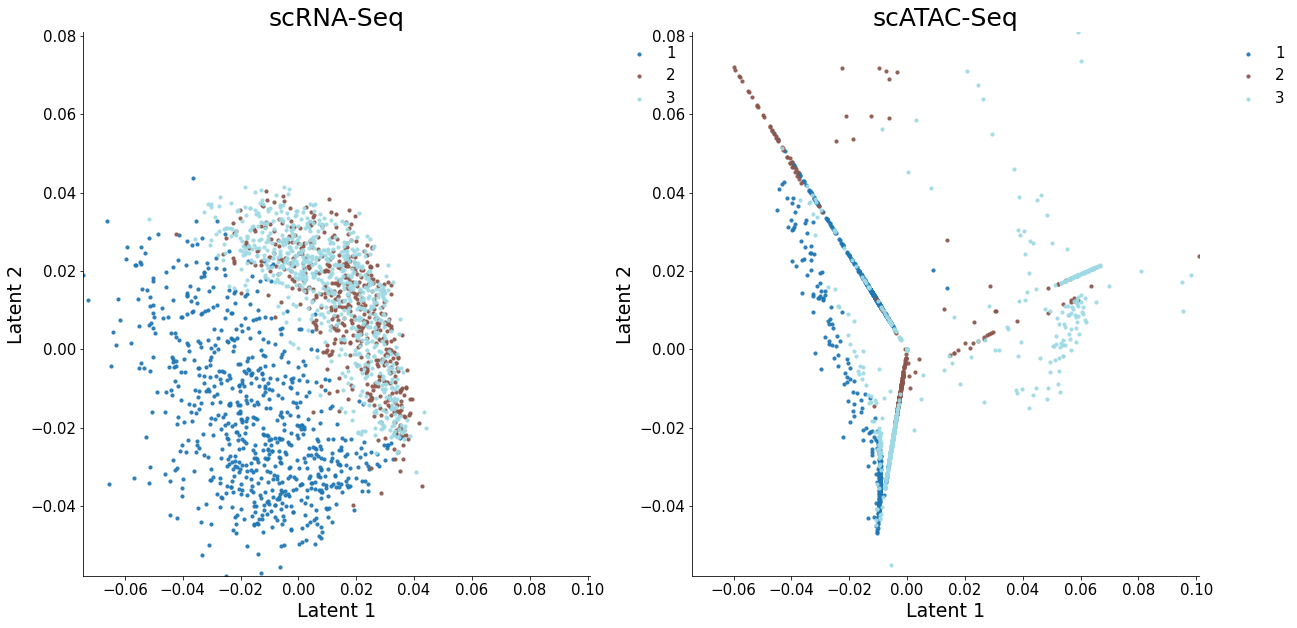

In [7]:
# z_rna = model.C_1g.detach().numpy()
# z_atac = model.C_2r.detach().numpy()
utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)